## Breast Cancer Dataset: Tutorial and Examples

### **Imports**

In [1]:
import pandas as pd
import numpy as np

import mlbugdetection
from mlbugdetection.load_data import load_dataset
from mlbugdetection.monotonic import monotonicity_mse, check_monotonicity_single_sample, check_monotonicity_multiple_samples
from mlbugdetection.critical_values import highest_and_lowest_indexes, find_critical_values, find_several_critical_values
from mlbugdetection.calibration import calibration_check
from mlbugdetection.sanity import sanity_check, sanity_check_with_indexes
from mlbugdetection.load_models import load_models_path

### **Load Data**
#### First, divide the data into the categories of malignant and benign tumors

In [2]:
df = load_dataset()
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
mal = df[df.diagnosis == "M"]
ben = df[df.diagnosis == "B"]

In [4]:
X_ben = ben.drop(columns=["diagnosis"])
X_ben.drop('id', axis=1, inplace=True) #drop redundant columns
X_mal = mal.drop(columns=["diagnosis"])
X_mal.drop('id', axis=1, inplace=True) #drop redundant columns

In [5]:
single_sample_ben = X_ben.sample(1, random_state=42)
single_sample_mal = X_mal.sample(1, random_state=42)

In [6]:
sample_ben = X_ben.sample(50, random_state=12)
sample_mal = X_mal.sample(50, random_state=11)


### Load the trained models that will be analyzed

In [7]:
model_path_knn, model_path_nn  = load_models_path()

### **Monotonicity analysis**
#### The monotonicity analysis module has two main functions: *check_monotonicity_single_sample* and *check_monotonicity_multiple_samples*.
#### The function *check_monotonicity_single_sample* receives a model, a single sample (one dataframe row), the feature that will be analyzed, the value interval of this feature, and the number of points analysed between this interval
#### The graph bellow shows that for a random sample of a benign tumor, the feature *perimeter_mean* has a monotonic behavior related to the prediction probability between the ranges 0 and 2000 using a MPLClassifier

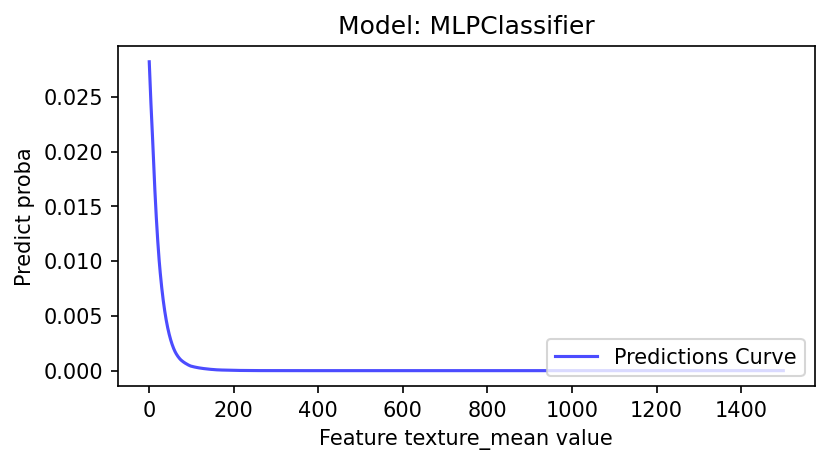

In [8]:
report_ben_mono = check_monotonicity_single_sample(model_path_nn, single_sample_ben, "texture_mean", 0,1500,0.1)

In [9]:
print(f"Model Name: {report_ben_mono.model_name}")
print(f"Analysed Feature: {report_ben_mono.analysed_feature}")
print(f"Feature Range: {report_ben_mono.feature_range}")
print(f"Metrics: {report_ben_mono.metrics}")

Model Name: MLPClassifier
Analysed Feature: texture_mean
Feature Range: (0, 1500)
Metrics: {'monotonic': True, 'monotonic_score': 1}


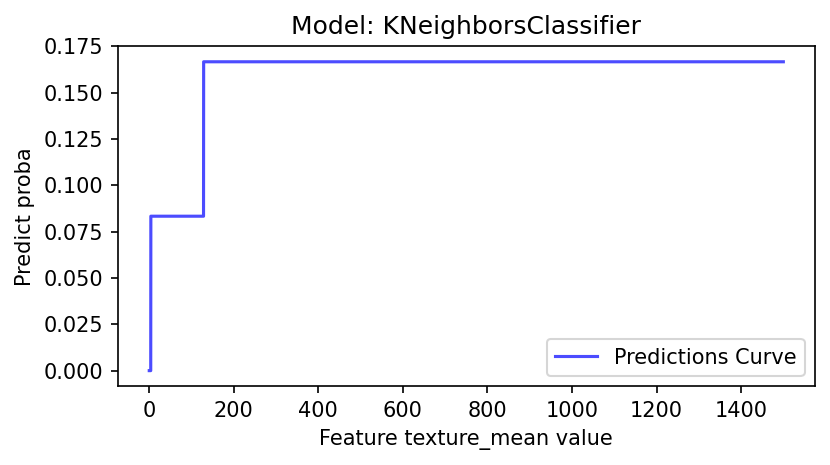

In [10]:
report_ben_mono2 = check_monotonicity_single_sample(model_path_knn, single_sample_ben, "texture_mean", 0,1500,0.1)

In [11]:
print(f"Model Name: {report_ben_mono2.model_name}")
print(f"Analysed Feature: {report_ben_mono2.analysed_feature}")
print(f"Feature Range: {report_ben_mono2.feature_range}")
print(f"Metrics: {report_ben_mono2.metrics}")


Model Name: KNeighborsClassifier
Analysed Feature: texture_mean
Feature Range: (0, 1500)
Metrics: {'monotonic': True, 'monotonic_score': 1}


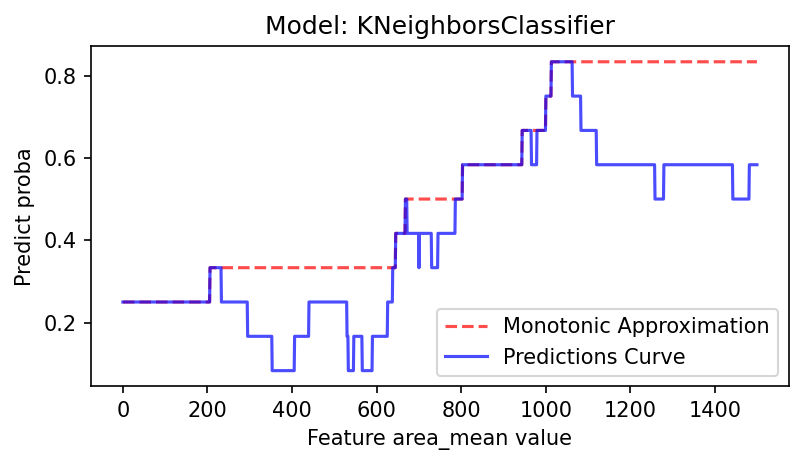

In [12]:
report_ben_mono3 = check_monotonicity_single_sample(model_path_knn, single_sample_ben, "area_mean", 0,1500,1)

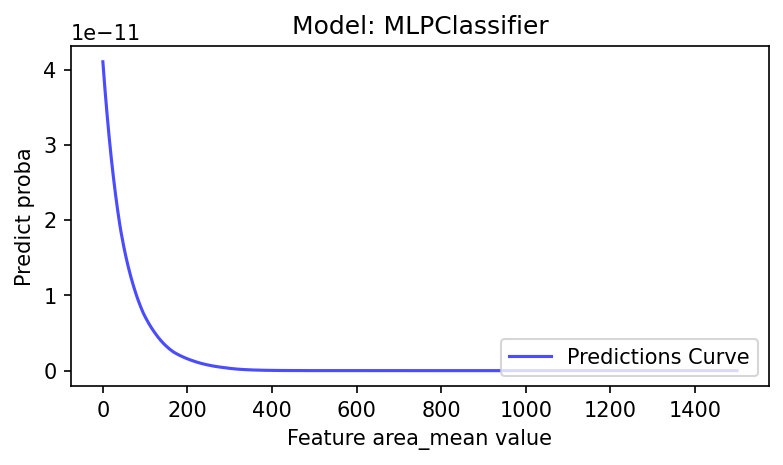

In [13]:
report_ben_mono4 = check_monotonicity_single_sample(model_path_nn, single_sample_ben, "area_mean", 0,1500,1)

In [14]:
print(f"Model Name: {report_ben_mono4.model_name}")
print(f"Analysed Feature: {report_ben_mono4.analysed_feature}")
print(f"Feature Range: {report_ben_mono4.feature_range}")
print(f"Metrics: {report_ben_mono4.metrics}")

Model Name: MLPClassifier
Analysed Feature: area_mean
Feature Range: (0, 1500)
Metrics: {'monotonic': True, 'monotonic_score': 1}


In [15]:
print(f"Model Name: {report_ben_mono3.model_name}")
print(f"Analysed Feature: {report_ben_mono3.analysed_feature}")
print(f"Feature Range: {report_ben_mono3.feature_range}")
print(f"Metrics: {report_ben_mono3.metrics}")

Model Name: KNeighborsClassifier
Analysed Feature: area_mean
Feature Range: (0, 1500)
Metrics: {'monotonic': False, 'monotonic_score': 0.0266712962962963}


#### For a similar example, but from a sample of a malignant tumor, the same feature presents a monotonic behavior as well

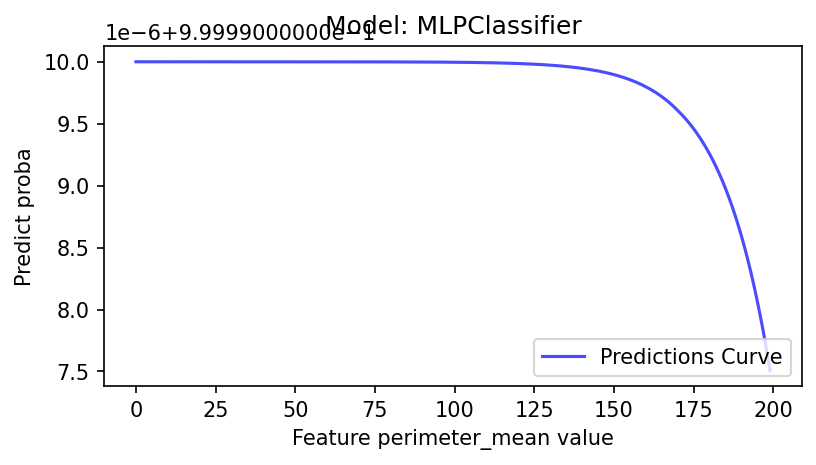

In [16]:
report_mal_mono = check_monotonicity_single_sample(model_path_nn, single_sample_mal, "perimeter_mean", 0,200,1)

#### The function *check_monotonicity_multiple_samples* receives a model, a sample containing multiple dataframe rows, the feature that will be analyzed, the value interval of this feature, and the number of points analysed between this interval
#### The graph bellow shows the mean prediction probability of the whole sample for each point analysed. In this case, the feature *area_mean* does not have a monotonic relationship with the mean prediction probability.

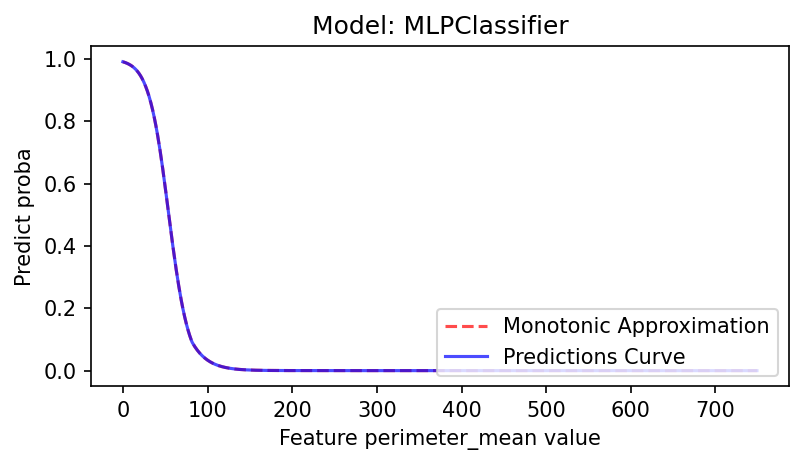

In [17]:
report_ben_mono_mult_nn = check_monotonicity_multiple_samples(model_path_nn, X_ben, "perimeter_mean", 0,750,1)

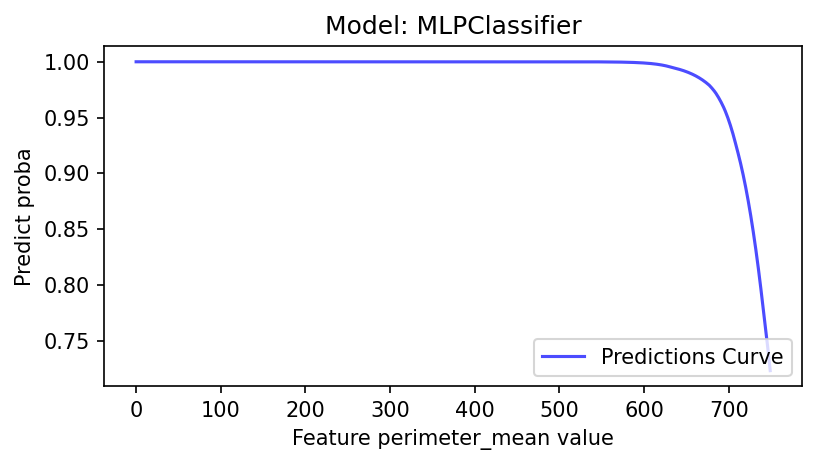

In [18]:
report_ben_mono_mult_nn2 = check_monotonicity_multiple_samples(model_path_nn, X_mal, "perimeter_mean", 0,750,1)

#### It is hard to identify how close the data is to a monotonic behavior only visualizing the graph. The method "monotonic_score" of the analysis report helps identifying it.

In [19]:
report_ben_mono_mult_nn.metrics

{'monotonic': False,
 'monotonic_score': 5.136550513173408e-12,
 'monotonic_means_std': 0.22865412567532453}

#### The MSE between the aproximated monotonic curve and the real curve is so small that it is possible to consider the real curve as monotonic.
#### Running the same sample in a KNN model shows a completely different result.

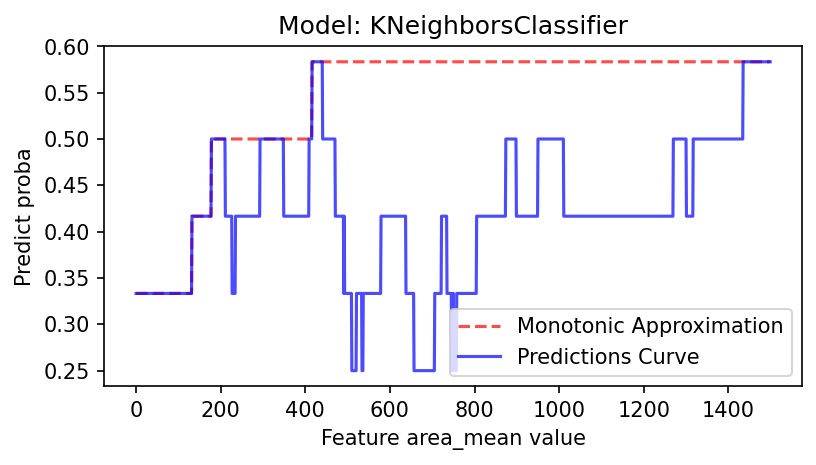

In [20]:
report_ben_mono_mult_knn = check_monotonicity_multiple_samples(model_path_knn, X_ben, "area_mean", 0,1500,1)

In [21]:
report_ben_mono_mult_knn.metrics

{'monotonic': False,
 'monotonic_score': 0.023407407407407415,
 'monotonic_means_std': 0.0779612122615083}

### **Critical values analysis**
#### The critical values analysis module has two main functions: *find_critical_values* and *find_several_critical_values*.
#### The analysed feature will be again *area_mean*, and this module identifies data examples and feature ranges that generate the biggest changes in the model's prediction probability, which can sometimes result in classification changes.


In [22]:
#First it will be analysed the model's behavior using the feature range from the training data
min_v = df["area_mean"].min()
max_v = df["area_mean"].max()

#### The find_several_critical_values functions shows the histogram of the means of the prediction probabilities changes, both for the positive changes (predict_proba[i] < predict_proba[i+1]) and the negative changes (predict_proba[i] > predict_proba[i+1])

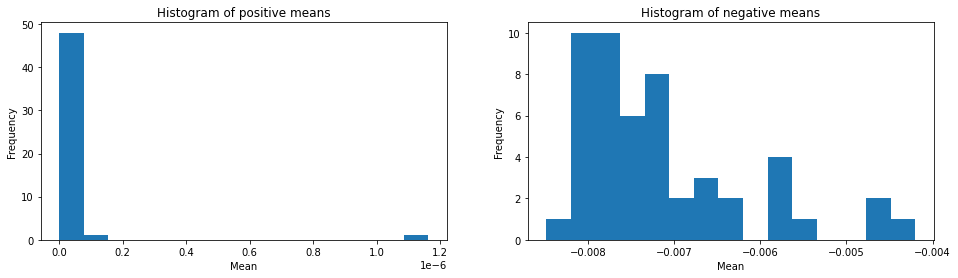

In [23]:
cvalues_mal = find_several_critical_values(model_path_nn, sample_mal, "area_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),1, keep_n = 50)

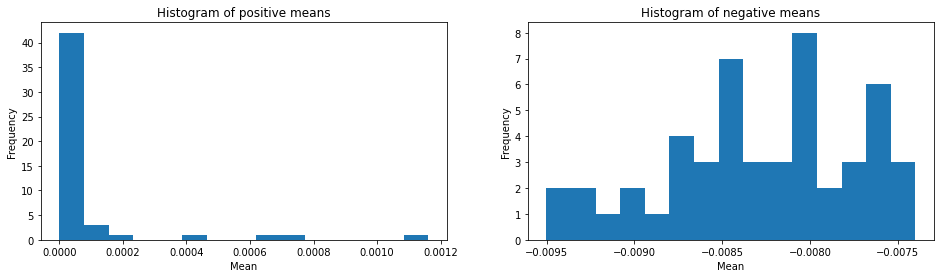

In [24]:
cvalues_ben = find_several_critical_values(model_path_nn, sample_ben, "area_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),1, keep_n = 50)

#### The analysis report object shows other metrics related to those positive and negative prediction probability changes means

In [25]:
print(f"Positive Means: {cvalues_ben.metrics['positive_means']}")
print(f"Negative Means: {cvalues_ben.metrics['negative_means']}")

Positive Means: {'mean': 7.436649129466536e-05, 'median': 1.495389287041111e-06, 'std': 0.0002140589520305116, 'var': 4.5821234944400866e-08}
Negative Means: {'mean': -0.008272643176716938, 'median': -0.00824789496557214, 'std': 0.000535512356806212, 'var': 2.8677348429214373e-07}


#### The analysis report object also shows other informations such as wich examples from the sample have cases where the model changes it`s category prediction ('critical_indexes')

In [26]:
cvalues_ben.metrics

{'critical_indexes': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'positive_means': {'mean': 7.436649129466536e-05,
  'median': 1.495389287041111e-06,
  'std': 0.0002140589520305116,
  'var': 4.5821234944400866e-08},
 'negative_means': {'mean': -0.008272643176716938,
  'median': -0.00824789496557214,
  'std': 0.000535512356806212,
  'var': 2.8677348429214373e-07}}

In [27]:
cvalues_mal.metrics["critical_indexes"]


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

#### Using the function find_critical_values it is possible to analyze some of the cases that the function find_several_critical_values detected as having critical values

In [28]:
#Some examples that the function find_several_critical_values detected as having critical values
t0 = sample_mal.iloc[[1]].copy()
t1 =sample_mal.iloc[[3]].copy()
t2 =sample_mal.iloc[[6]].copy()
t3 = sample_mal.iloc[[8]].copy()
t4 = sample_mal.iloc[[11]].copy()
t5 =sample_mal.iloc[[34]].copy()

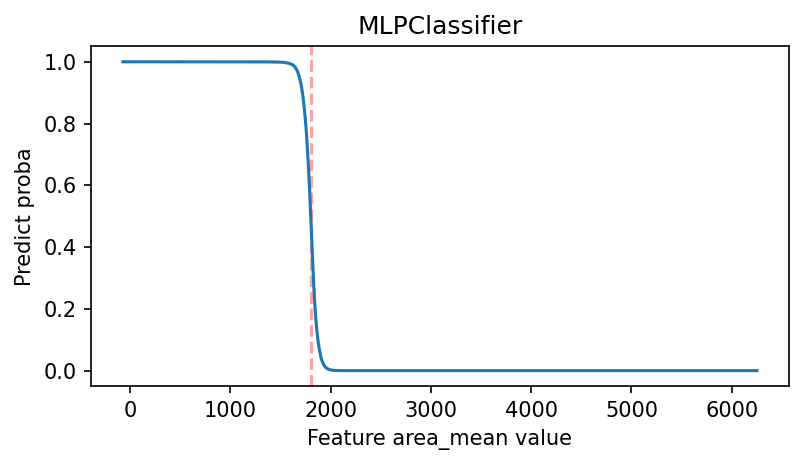

In [29]:
cvalues_ben1 = find_critical_values(model_path_nn, t0, "area_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),1, keep_n = 50)

#### The following code shows the feature range that results in a category change by the model

In [30]:
for k, v in (cvalues_ben1.metrics['negative_changes'].items()):
    if (v['proba'][0] >= 0.5 and v['proba'][1] < 0.5):
        print(v['ranges'])

(1801.25, 1802.25)


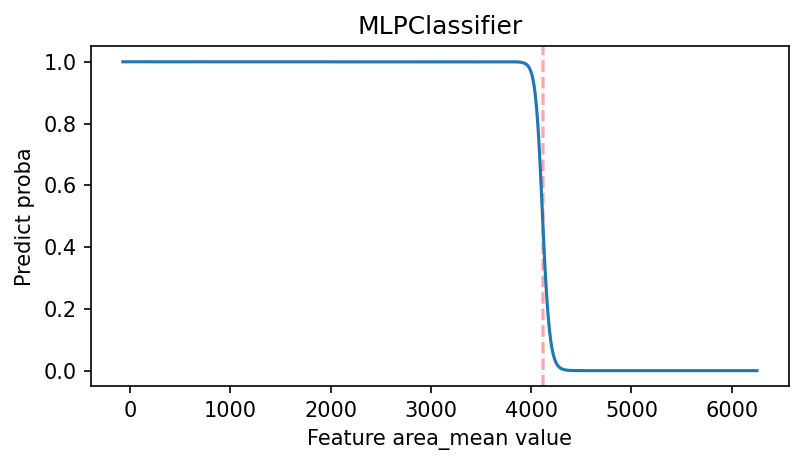

In [31]:
cvalues_ben2 = find_critical_values(model_path_nn, t1, "area_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),1, keep_n = 50)

In [36]:
for k, v in (cvalues_ben2.metrics['negative_changes'].items()):
    if (v['proba'][0] >= 0.5 and v['proba'][1] < 0.5):
        print(v['ranges'])

(4113.25, 4114.25)


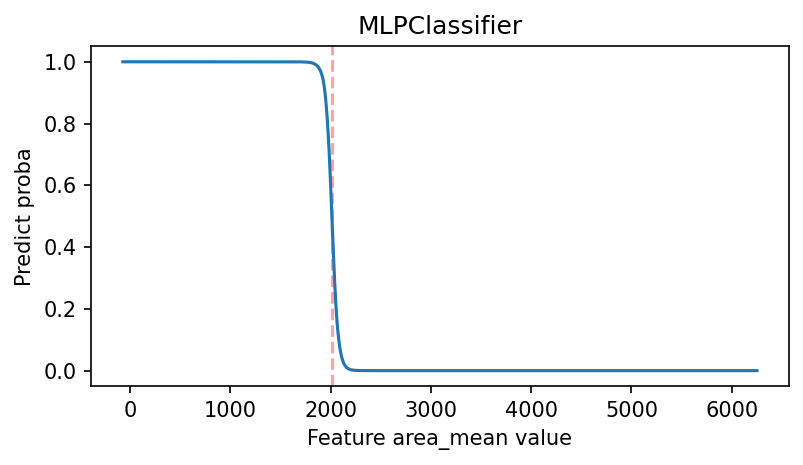

In [32]:
cvalues_ben3 = find_critical_values(model_path_nn, t2, "area_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),1, keep_n = 50)

In [37]:
for k, v in (cvalues_ben3.metrics['negative_changes'].items()):
    if (v['proba'][0] >= 0.5 and v['proba'][1] < 0.5):
        print(v['ranges'])

(2012.25, 2013.25)


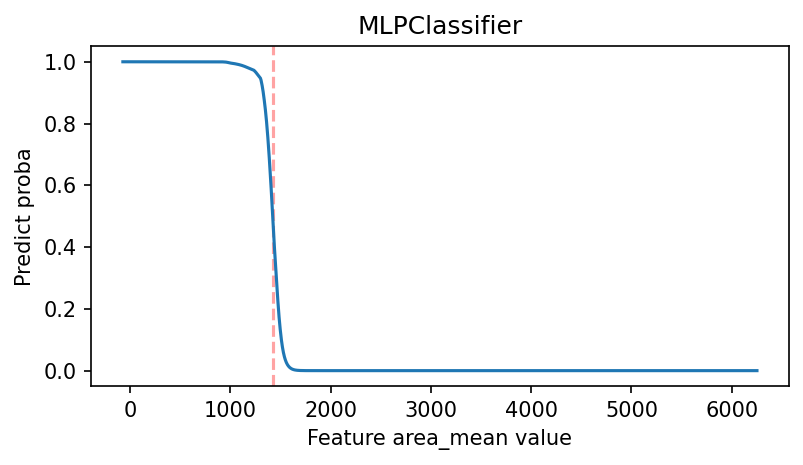

In [33]:
cvalues_ben4 = find_critical_values(model_path_nn, t3, "area_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),1, keep_n = 50)

In [38]:
for k, v in (cvalues_ben4.metrics['negative_changes'].items()):
    if (v['proba'][0] >= 0.5 and v['proba'][1] < 0.5):
        print(v['ranges'])

(1421.25, 1422.25)


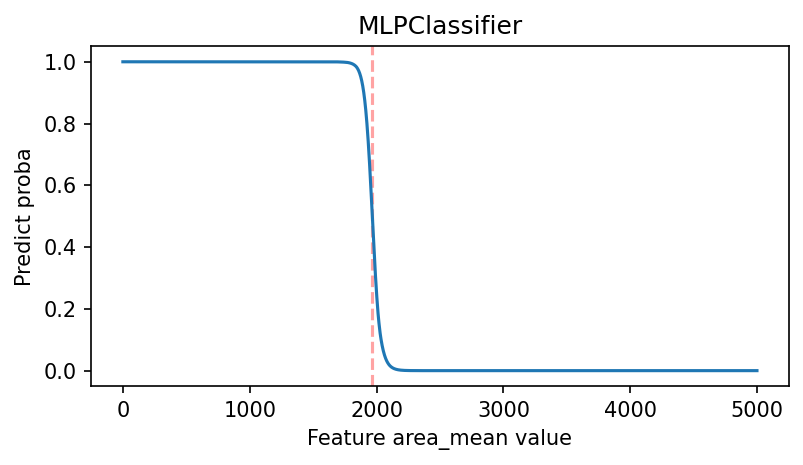

In [39]:
cvalues_ben5 = find_critical_values(model_path_nn, t4, "area_mean",0,5000,1, keep_n = 50)

In [40]:
for k, v in (cvalues_ben5.metrics['negative_changes'].items()):
    if (v['proba'][0] >= 0.5 and v['proba'][1] < 0.5):
        print(v['ranges'])

(1966, 1967)


In [49]:
import pickle
with open(model_path_knn, 'rb') as f:
    knn = pickle.load(f)

#### The function *sanity_check* receives a model, a sample (one or more examples) the target label, and alanyzes if the model correctly predicts the category of this sample. The function *sanity_check_with_indexes* does the same analyzes but return the indexes of the cases that the model predicted incorrectly.

In [51]:
sanity_check1 = sanity_check(knn, mal.drop(columns='id'), 'diagnosis')

In [53]:
sanity_check1

False

In [54]:
sanity_check2 = sanity_check_with_indexes(knn, mal.drop(columns='id'), 'diagnosis')

In [56]:
sanity_check2.metrics

{'sanity': False,
 'sanity_indexes': [3,
  5,
  8,
  9,
  13,
  14,
  23,
  33,
  34,
  35,
  37,
  40,
  42,
  59,
  61,
  64,
  79,
  82,
  97,
  99,
  112,
  113,
  117,
  145,
  158,
  168,
  169,
  177,
  189,
  195,
  205]}